In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
color_pal = sns.color_palette()
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv("healthcare_product_sales.csv")

In [3]:
data.value_counts()

Date        Product_Category    Units_Sold  Revenue    
2019-01-01  Cold Remedies       253         2384.938124    1
2022-05-02  Skin Care           177         3491.173030    1
2022-05-01  Pain Relievers      489         7927.504722    1
            Skin Care           231         3617.462007    1
            Vitamins            350         6496.596718    1
                                                          ..
2020-08-30  Skin Care           512         4686.604977    1
            Pain Relievers      496         5617.603696    1
            First Aid Supplies  146         2146.854848    1
            Cold Remedies       45          758.927750     1
2023-12-31  Vitamins            281         3540.108250    1
Name: count, Length: 9130, dtype: int64

In [4]:
data = data.set_index("Date")
data.index = pd.to_datetime(data.index)

# Let's first build a model on Pain Relievers

In [5]:
painrelievers = data[data["Product_Category"] == "Pain Relievers"]

In [6]:

painrelievers = painrelievers[['Units_Sold']]

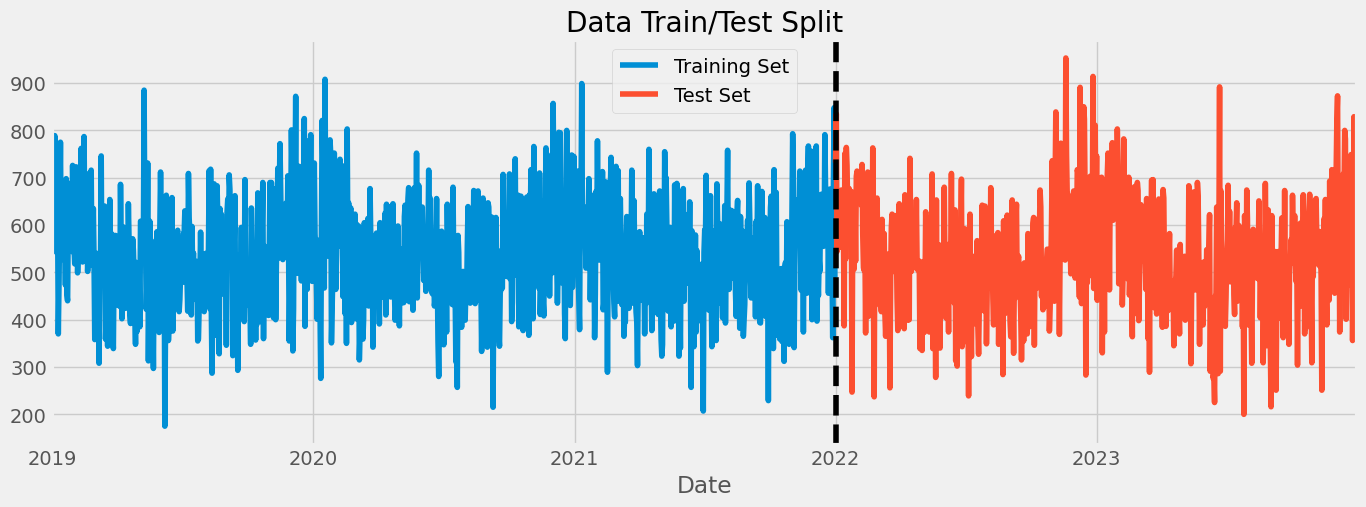

In [7]:


train= painrelievers.loc[painrelievers.index < '01-01-2022']
test = painrelievers.loc[painrelievers.index >= '01-01-2022']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Feature Creation

In [8]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(painrelievers)

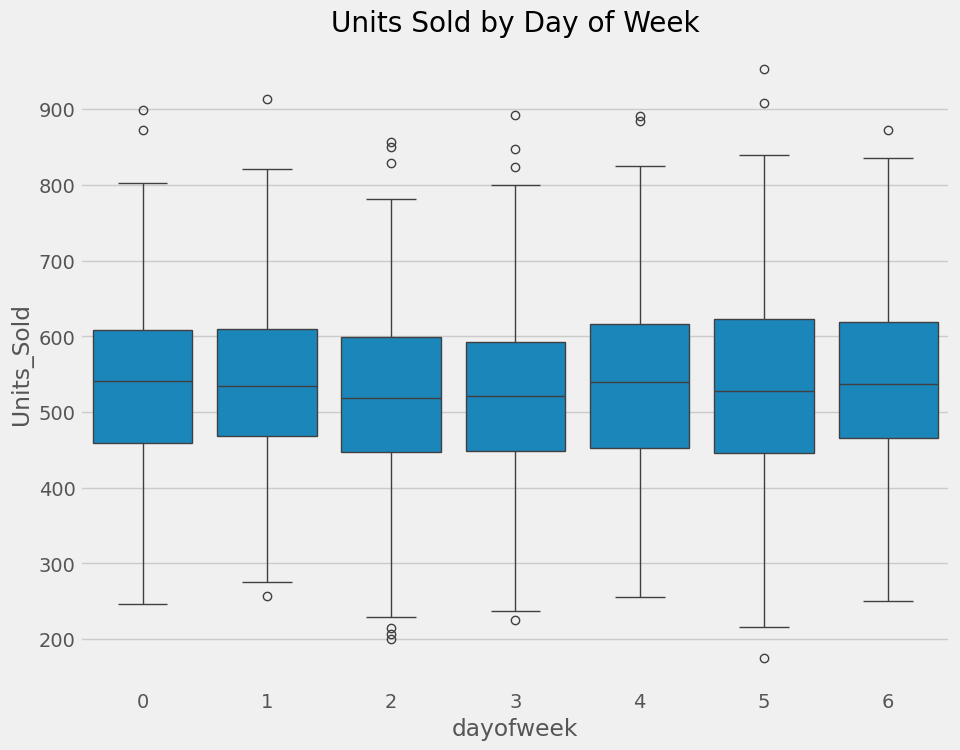

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='Units_Sold')
ax.set_title('Units Sold by Day of Week')
plt.show()

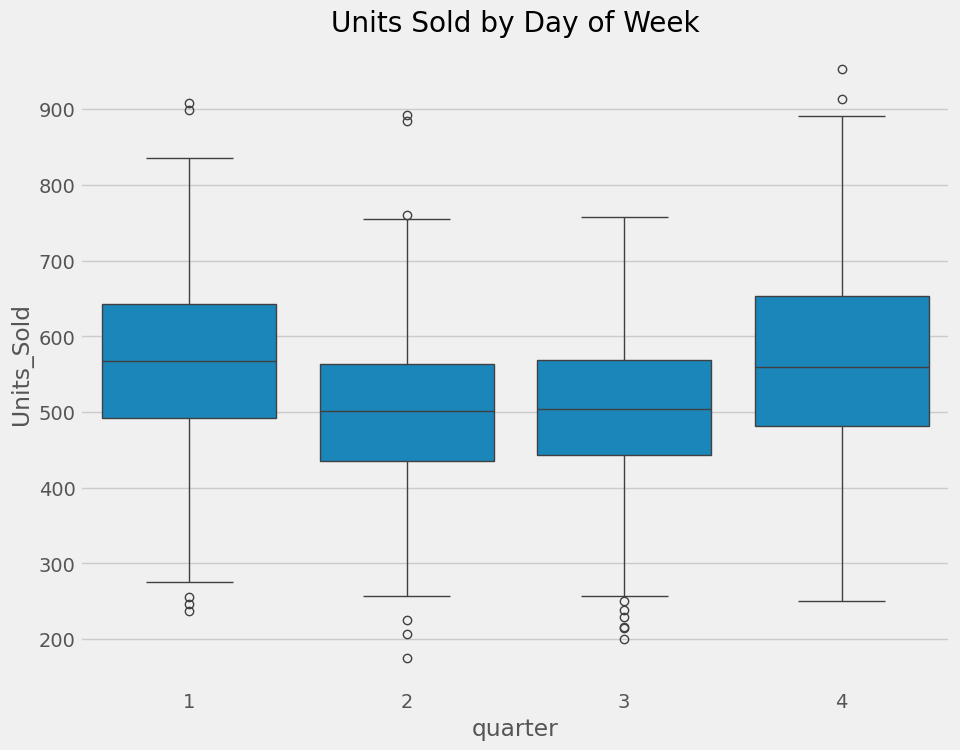

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='Units_Sold')
ax.set_title('Units Sold by Day of Week')
plt.show()

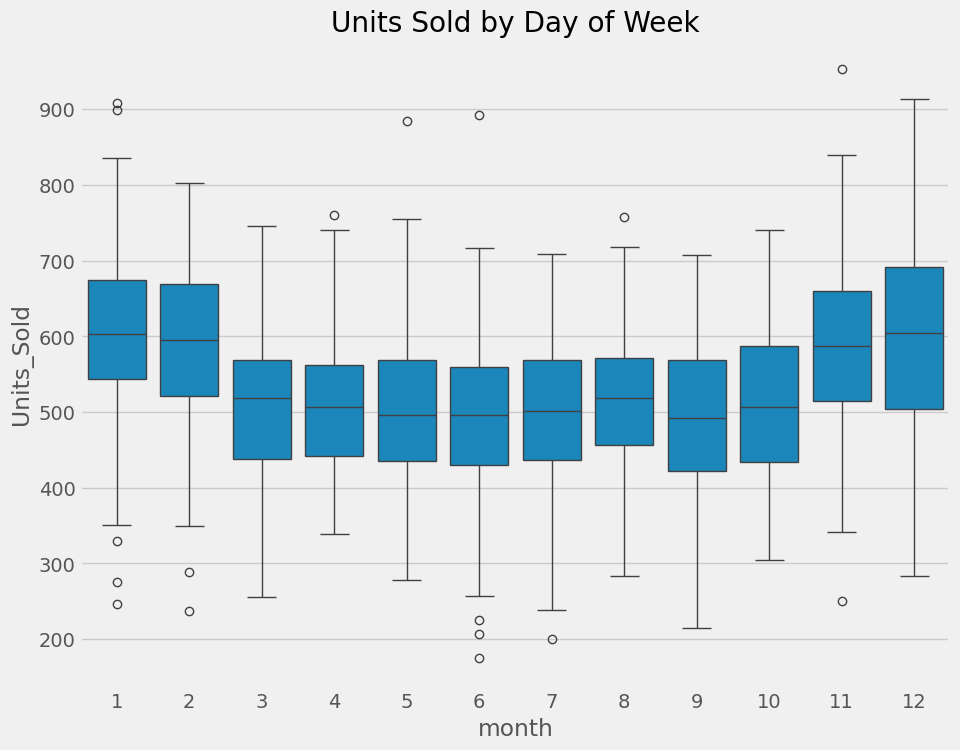

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Units_Sold')
ax.set_title('Units Sold by Day of Week')
plt.show()

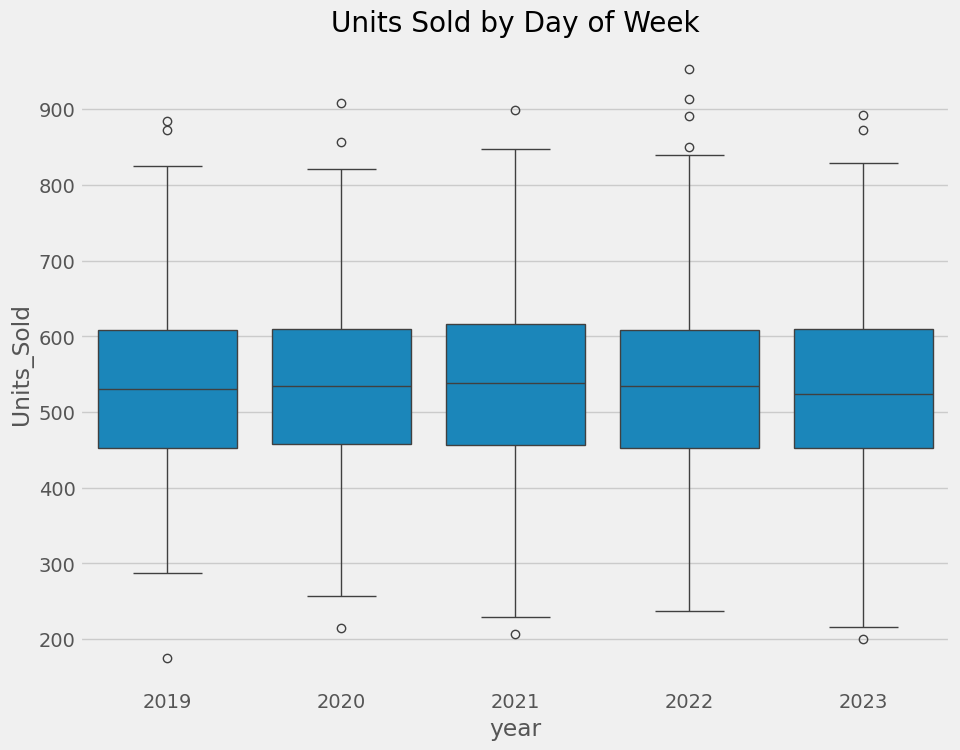

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='Units_Sold')
ax.set_title('Units Sold by Day of Week')
plt.show()

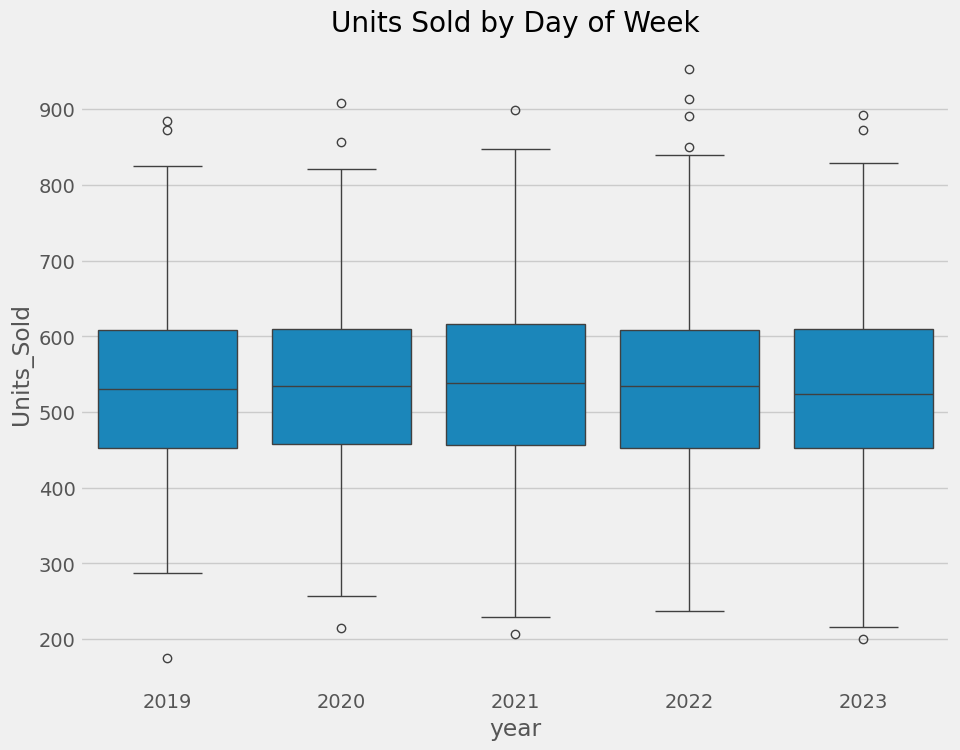

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='Units_Sold')
ax.set_title('Units Sold by Day of Week')
plt.show()

# Model Creation

In [14]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofmonth', 'dayofweek','weekofyear', 'quarter', 'month', 'year']
TARGET = 'Units_Sold'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]
X_train['weekofyear'] = X_train['weekofyear'].astype('int32')
X_test['weekofyear'] = X_test['weekofyear'].astype('int32')


In [15]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[21:50:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:542.07124	validation_1-rmse:538.37786
[100]	validation_0-rmse:221.03739	validation_1-rmse:219.44622
[200]	validation_0-rmse:124.65865	validation_1-rmse:128.12489
[300]	validation_0-rmse:104.07485	validation_1-rmse:111.95597
[400]	validation_0-rmse:99.98256	validation_1-rmse:110.26442
[465]	validation_0-rmse:98.87625	validation_1-rmse:110.35184


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# Feature Importance

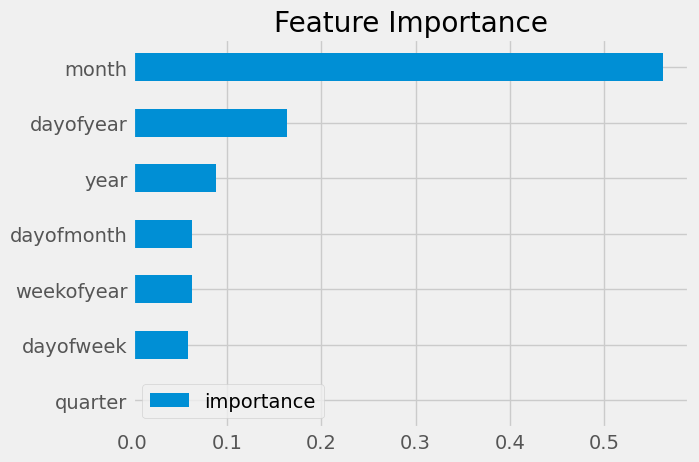

In [16]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()


# Forecast on Test

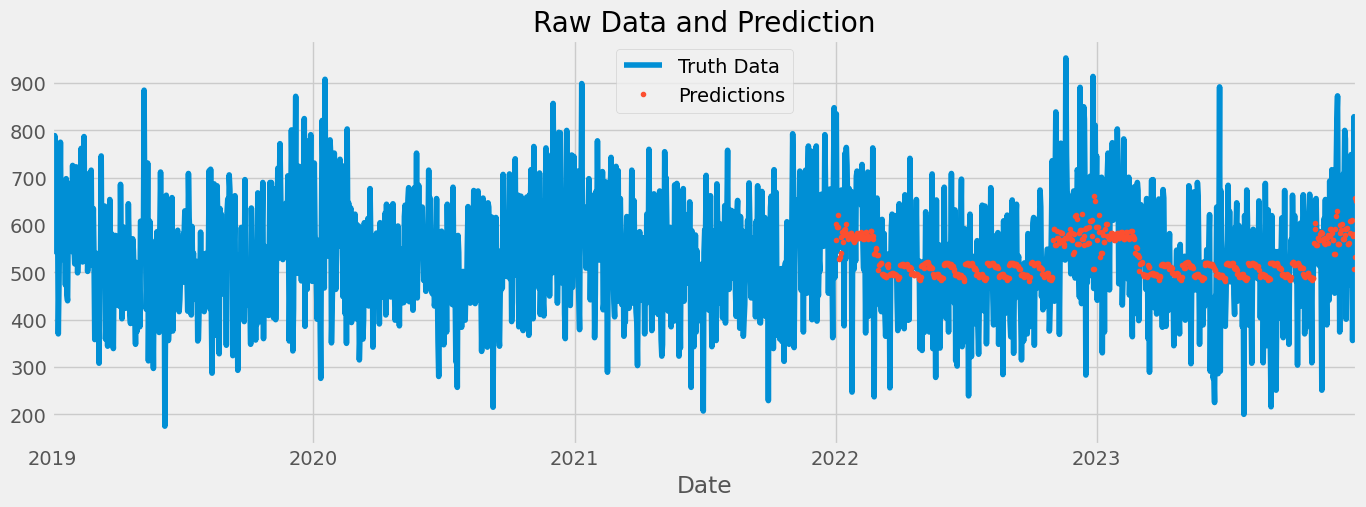

In [17]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Units_Sold']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [18]:
score = np.sqrt(mean_squared_error(test['Units_Sold'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 110.24


# Cross-Validation to Test Robustness of Model

In [19]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size= 182, gap=24)
df = df.sort_index()

In [20]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year', 'dayofmonth', 'weekofyear']
    TARGET = 'Units_Sold'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    X_train['weekofyear'] = X_train['weekofyear'].astype('int32')
    X_test['weekofyear'] = X_test['weekofyear'].astype('int32')

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[21:50:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:542.48215	validation_1-rmse:549.90008
[100]	validation_0-rmse:221.25489	validation_1-rmse:227.66197
[200]	validation_0-rmse:124.61272	validation_1-rmse:131.14692
[300]	validation_0-rmse:103.56904	validation_1-rmse:109.93122
[400]	validation_0-rmse:99.21575	validation_1-rmse:105.90333
[500]	validation_0-rmse:97.50514	validation_1-rmse:105.05255
[566]	validation_0-rmse:96.65657	validation_1-rmse:105.20560
[21:50:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:540.72114	validation_1-rmse:533.82829
[100]	validation_0-rmse:220.59002	validation_1-rmse:214.75012
[200]	validation_0-rm

In [21]:
scores

[105.0283020661534,
 102.71166445428712,
 110.53307967366159,
 112.60893260222609,
 110.81715351758758]

All of these scores are stable, which signals that our model is robust. However, we can continue to optimize our model with Grid Search.

 # Grid Search

In [22]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb

param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = ParameterGrid(param_grid)

best_params = None
best_score = float('inf')
all_scores = []


fold = 0
tss = TimeSeriesSplit(n_splits=5)  
for params in grid:
    fold_scores = []
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        train = create_features(train)
        test = create_features(test)

        FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'dayofmonth', 'weekofyear']
        TARGET = 'Units_Sold'

        X_train = train[FEATURES]
        y_train = train[TARGET]
        X_test = test[FEATURES]
        y_test = test[TARGET]
        
        X_train['weekofyear'] = X_train['weekofyear'].astype('int32')
        X_test['weekofyear'] = X_test['weekofyear'].astype('int32')

    
        reg = xgb.XGBRegressor(
            base_score=0.5,
            booster='gbtree',
            early_stopping_rounds=50,
            objective='reg:squarederror', 
            **params
        )

        reg.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False 
        )

        y_pred = reg.predict(X_test)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        fold_scores.append(score)

    mean_score = np.mean(fold_scores)
    all_scores.append((params, mean_score))

    if mean_score < best_score:
        best_score = mean_score
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_score:.4f}")


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Best RMSE: 108.8787


In [23]:
df.index.max()

Timestamp('2023-12-31 00:00:00')

# Create a future dataframe

In [24]:

future = pd.date_range('2023-12-31','2024-12-31', freq='d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)

In [25]:
future_w_features = df_and_future.query('isFuture').copy()

In [26]:
future_w_features['weekofyear'] = future_w_features['weekofyear'].astype('int32')

In [27]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

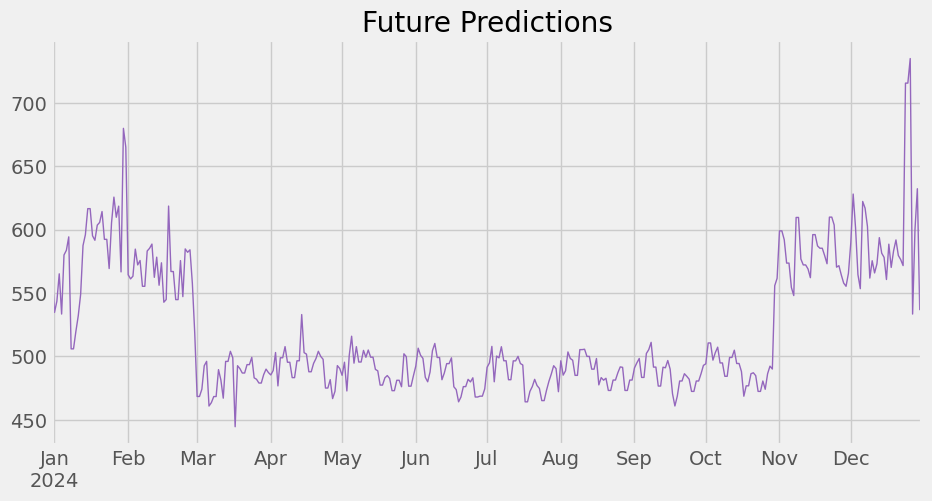

In [28]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [29]:
df['pred'] = df['Units_Sold']

In [30]:
combined_with_pred = pd.concat([df, future_w_features], axis = 0)

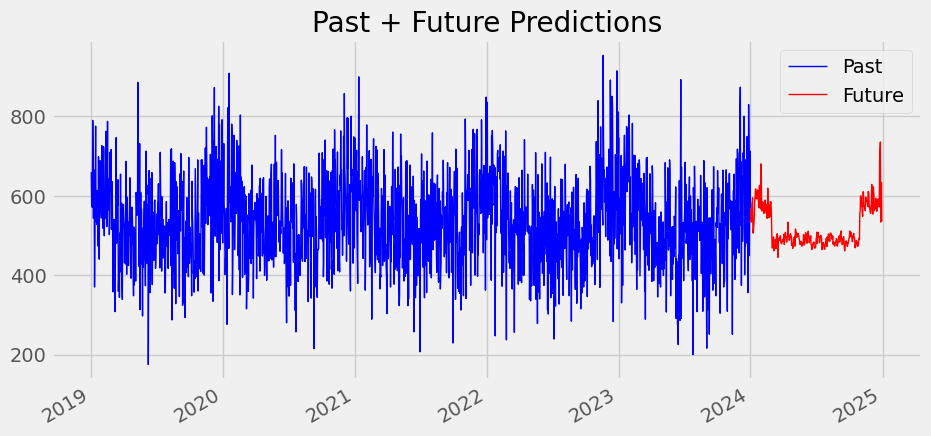

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

cutoff_date = pd.Timestamp('2023-12-31')

# Split the data
past_data = combined_with_pred[combined_with_pred.index <= cutoff_date]
future_data = combined_with_pred[combined_with_pred.index > cutoff_date]

# Create the plot
plt.figure(figsize=(10, 5))

# Plot past data
past_data['pred'].plot(color='blue', ms=1, lw=1, label='Past')

# Plot future data
future_data['pred'].plot(color='red', ms=1, lw=1, label='Future')

plt.title('Past + Future Predictions')
plt.legend()
plt.show()

# Now let's repeat the process for other categories of drugs

# Vitamins

In [33]:
data = pd.read_csv("healthcare_product_sales.csv")

In [34]:
Vitamin_cv = XGBoostCV(data, 'Vitamins')

[0]	validation_0-rmse:318.62661	validation_1-rmse:314.42321
[100]	validation_0-rmse:131.11379	validation_1-rmse:127.16160
[200]	validation_0-rmse:75.38259	validation_1-rmse:73.68372
[300]	validation_0-rmse:63.43988	validation_1-rmse:64.19187
[400]	validation_0-rmse:60.95905	validation_1-rmse:63.09670
[494]	validation_0-rmse:59.97936	validation_1-rmse:63.12273


In [35]:
Vitamin_cv.generalization()

[21:51:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_o

[58.73281182013148]

In [36]:
Vitamin_cv.grid_search()

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Best Error: 63.89253357740995


{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 500,
 'subsample': 1.0}

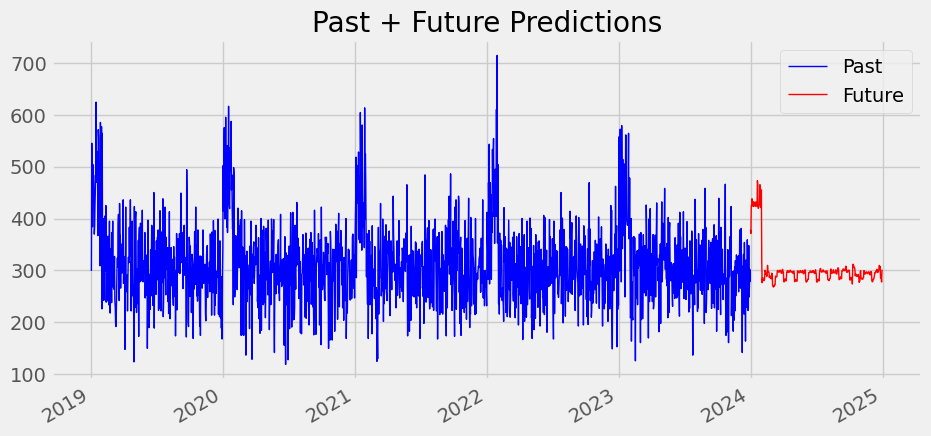

In [37]:
Vitamin_cv.graph_future()

[0]	validation_0-rmse:318.62661	validation_1-rmse:314.42321
[100]	validation_0-rmse:131.11379	validation_1-rmse:127.16160
[200]	validation_0-rmse:75.38259	validation_1-rmse:73.68372
[300]	validation_0-rmse:63.43988	validation_1-rmse:64.19187
[400]	validation_0-rmse:60.95905	validation_1-rmse:63.09670
[495]	validation_0-rmse:59.96658	validation_1-rmse:63.12529


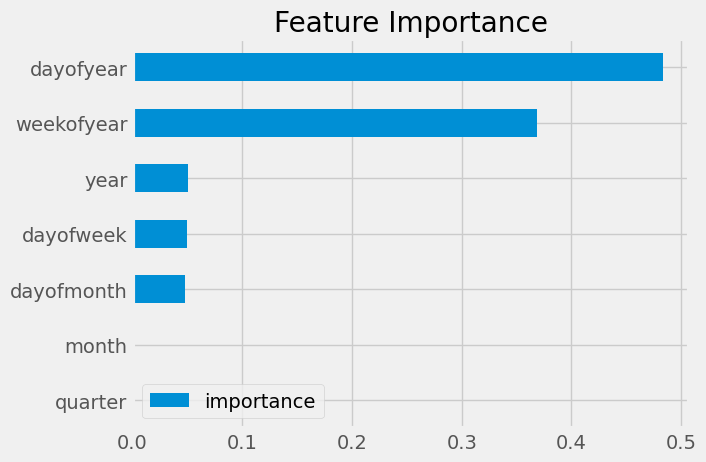

In [38]:
vitamin_XG = XG_TimeSeries(data, 'Vitamins')
vitamin_XG.feature_importance_plot()

# Cold Remedies

In [40]:
cold_cv = XGBoostCV(data, 'Cold Remedies')

[0]	validation_0-rmse:238.44219	validation_1-rmse:241.44119
[100]	validation_0-rmse:96.95419	validation_1-rmse:100.01728
[200]	validation_0-rmse:53.60502	validation_1-rmse:57.06370
[300]	validation_0-rmse:43.75619	validation_1-rmse:47.71979
[400]	validation_0-rmse:41.27799	validation_1-rmse:46.36244
[491]	validation_0-rmse:40.00415	validation_1-rmse:46.33117


In [41]:
cold_cv.generalization()

[21:51:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_o

[38.914800040336]

In [42]:
cold_cv.grid_search()

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Best Error: 47.76444987313402


{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 500,
 'subsample': 1.0}

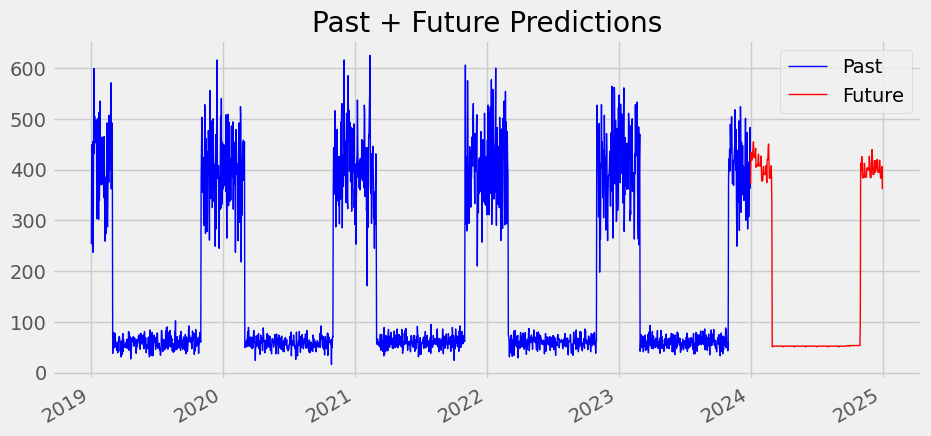

In [43]:
cold_cv.graph_future()

[0]	validation_0-rmse:238.44219	validation_1-rmse:241.44119
[100]	validation_0-rmse:96.95419	validation_1-rmse:100.01728
[200]	validation_0-rmse:53.60502	validation_1-rmse:57.06370
[300]	validation_0-rmse:43.75619	validation_1-rmse:47.71979
[400]	validation_0-rmse:41.27799	validation_1-rmse:46.36244
[491]	validation_0-rmse:40.00415	validation_1-rmse:46.33117


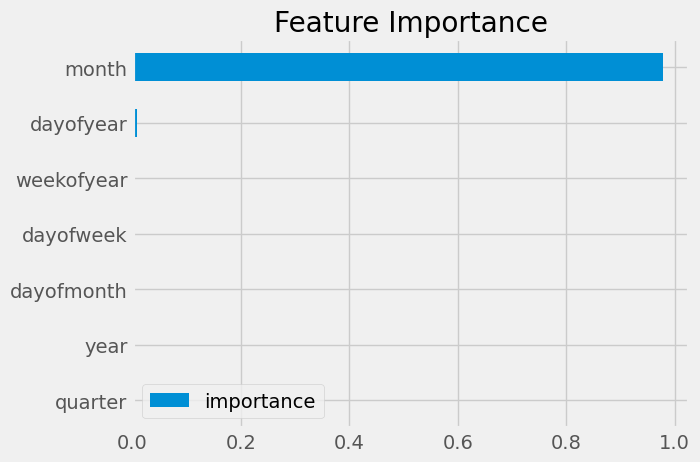

In [44]:
cold_xg = XG_TimeSeries(data, 'Cold Remedies')
cold_xg.feature_importance_plot()

# Skin Care

In [46]:
skin_cv = XGBoostCV(data, 'Skin Care')

[0]	validation_0-rmse:283.27086	validation_1-rmse:289.05210
[100]	validation_0-rmse:115.88631	validation_1-rmse:121.28397
[200]	validation_0-rmse:65.97663	validation_1-rmse:70.48023
[300]	validation_0-rmse:55.51120	validation_1-rmse:59.23457
[400]	validation_0-rmse:53.31971	validation_1-rmse:57.42174
[500]	validation_0-rmse:52.35496	validation_1-rmse:57.06910
[600]	validation_0-rmse:51.71650	validation_1-rmse:57.01800
[603]	validation_0-rmse:51.69804	validation_1-rmse:57.01776


In [47]:
skin_cv.generalization()

[21:51:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_o

[64.71859959480194]

In [48]:
skin_cv.grid_search()

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Best Error: 55.320852944556655


{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 500,
 'subsample': 1.0}

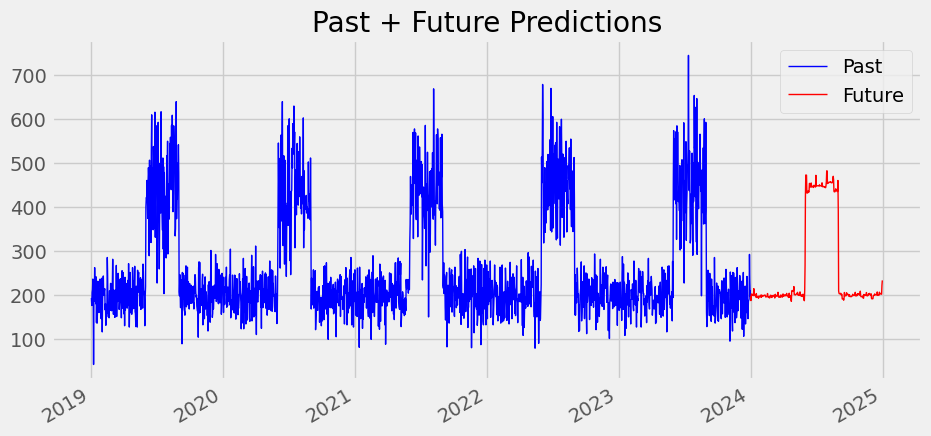

In [49]:
skin_cv.graph_future()

[0]	validation_0-rmse:283.27086	validation_1-rmse:289.05210
[100]	validation_0-rmse:115.88631	validation_1-rmse:121.28397
[200]	validation_0-rmse:65.97663	validation_1-rmse:70.48023
[300]	validation_0-rmse:55.51120	validation_1-rmse:59.23457
[400]	validation_0-rmse:53.31971	validation_1-rmse:57.42174
[500]	validation_0-rmse:52.35496	validation_1-rmse:57.06910
[600]	validation_0-rmse:51.71650	validation_1-rmse:57.01800
[603]	validation_0-rmse:51.69804	validation_1-rmse:57.01776


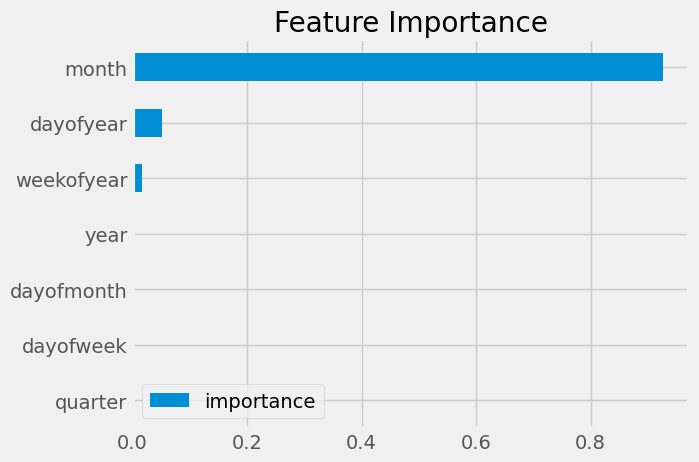

In [50]:
skin_xg = XG_TimeSeries(data, 'Skin Care')
skin_xg.feature_importance_plot()

# First Aid

In [54]:
first_cv = XGBoostCV(data, 'First Aid Supplies')

[0]	validation_0-rmse:151.78956	validation_1-rmse:155.11515
[100]	validation_0-rmse:64.45255	validation_1-rmse:67.59764
[200]	validation_0-rmse:39.77267	validation_1-rmse:42.60102
[300]	validation_0-rmse:34.75412	validation_1-rmse:37.18396
[400]	validation_0-rmse:33.71268	validation_1-rmse:36.15472
[500]	validation_0-rmse:33.30334	validation_1-rmse:35.97219
[594]	validation_0-rmse:33.01975	validation_1-rmse:35.95074


In [55]:
first_cv.generalization()

[21:52:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:52:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:52:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:52:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:52:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_o

[37.17958628129268]

In [56]:
first_cv.grid_search()

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1.0}
Best Error: 36.09909448514502


{'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 1000,
 'subsample': 1.0}

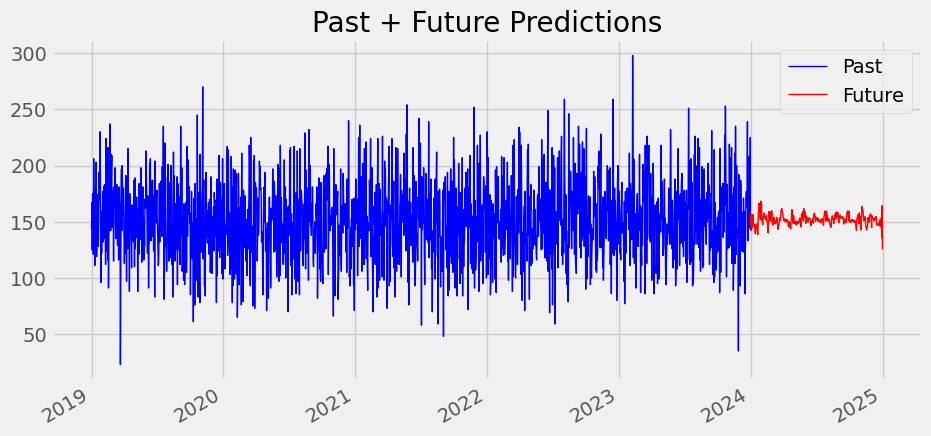

In [57]:
first_cv.graph_future()

[0]	validation_0-rmse:151.78956	validation_1-rmse:155.11515
[100]	validation_0-rmse:64.45255	validation_1-rmse:67.59764
[200]	validation_0-rmse:39.77267	validation_1-rmse:42.60102
[300]	validation_0-rmse:34.75412	validation_1-rmse:37.18396
[400]	validation_0-rmse:33.71268	validation_1-rmse:36.15472
[500]	validation_0-rmse:33.30334	validation_1-rmse:35.97219
[593]	validation_0-rmse:33.02529	validation_1-rmse:35.95199


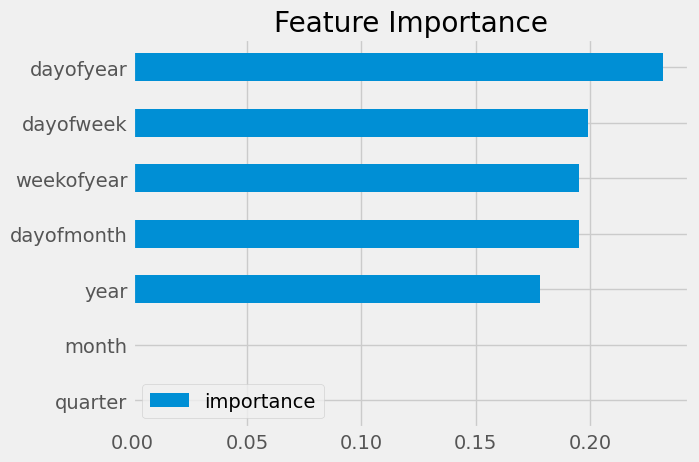

In [58]:
first_xg = XG_TimeSeries(data, 'First Aid Supplies')
first_xg.feature_importance_plot()